In [56]:
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import ticker
from mpl_toolkits.mplot3d import Axes3D
import sklearn.preprocessing as skprocess
from sklearn import ensemble, metrics, neighbors
from pandas_datareader import data as pd_data
from matplotlib import cm

In [57]:
%matplotlib inline
np.set_printoptions(precision=4)
pd.options.display.precision = 4
mpl.pyplot.style.use('seaborn-talk')
presentation_fontsize=22
# mpl.rc('font', **{'family':'sans-serif', 'sans-serif':'cm'})
mpl.rc('legend', **{'fontsize':presentation_fontsize})
mpl.rc('axes', **{'labelsize':presentation_fontsize, 'titlesize':presentation_fontsize})
mpl.rc('xtick', **{'labelsize':presentation_fontsize})
mpl.rc('ytick', **{'labelsize': presentation_fontsize})


In [58]:
treasury_yield = pd_data.get_data_fred('DGS10', start='1950', end='2018').apply(
    lambda x: np.log(x/(100 * 365) + 1)).rename(columns={'DGS10':'log_yield'})

In [59]:
volatility_store = pd.HDFStore('../results/spy_volatility_estimates_2003-2014.hdf')
# volatility_store = pd.HDFStore('../results/xlr_volatility_estimates_2005-2014.tmp.hdf')
discrete_vol = volatility_store['discrete_trunc_vol']
daily_rtn = (treasury_yield.T - volatility_store['daily_rtn']).T.dropna()
daily_rtn.columns = ['daily_rtn']

In [60]:
fed_announcement_dates = pd.read_hdf('../results/fomc_times.hdf', 'table')
fomc_dates = pd.DataFrame(np.ones((fed_announcement_dates.size,1)), 
                          index=fed_announcement_dates['FOMC_times']).resample('D').last().fillna(0).rename(
    columns={0:'fomc_dates'})

In [61]:
data =  pd.concat([fomc_dates,discrete_vol, daily_rtn], axis=1).dropna()
data = data.resample('2D').sum()
data['root_quad'] = np.log(data['diffusion'] + data['jumps'])
data['jump_prop'] =  (data.jumps / (data.jumps + data.diffusion)).to_frame().rename(
    columns={0:'jump_prop'})
data.dropna(inplace=True)

In [62]:
announcement_data = data.query('fomc_dates == 1')
non_announcment_data = data.query('fomc_dates == 0')

In [63]:
regressors = data.loc[:, ['root_quad', 'jump_prop']]
regressand = data.daily_rtn
test_regressors = announcement_data.loc[:, ['root_quad', 'jump_prop']]
test_regressand = announcement_data.daily_rtn

In [64]:
random_forest_model = ensemble.RandomForestRegressor(n_estimators=5, max_depth=1, max_features=2, 
                                                     oob_score=True, criterion='mae', bootstrap=True)
fitted_model = random_forest_model.fit(regressors,regressand)
prediction = fitted_model.predict(X=test_regressors)

/home/sangrey/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [65]:
(( np.abs(np.median(prediction) - announcement_data.daily_rtn.median()))
 / np.abs(non_announcment_data.daily_rtn.median() - announcement_data.daily_rtn.median()))

0.69228303482163123

In [66]:
(metrics.mean_absolute_error(y_pred=prediction, 
                             y_true=announcement_data.daily_rtn) 
 / np.mean(np.abs(non_announcment_data.daily_rtn.mean() - announcement_data.daily_rtn)))

1.0289250650797852

In [67]:
neighbors_model = neighbors.KNeighborsRegressor(weights='uniform', n_neighbors=40)
neighbors_fitted_model = neighbors_model.fit(regressors,regressand)
neighbors_prediction = neighbors_fitted_model.predict(X=test_regressors)

In [68]:
(metrics.mean_absolute_error(neighbors_prediction, announcement_data.daily_rtn) 
 / np.mean(np.abs(non_announcment_data.daily_rtn.mean() - announcement_data.daily_rtn)))

1.0003682866480668

In [69]:
(( np.abs(np.median(neighbors_prediction) - announcement_data.daily_rtn.median()))
 /np.abs(non_announcment_data.daily_rtn.median() - announcement_data.daily_rtn.median()))

1.250949147274073

In [70]:
from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit, LeaveOneOut, LeavePOut

In [71]:
def set_model_params(model_class, n_splits=5, **params):
    kf = ShuffleSplit(n_splits=n_splits, test_size=.3)
#     kf = LeavePOut(p=200)
    scores = []
    model = model_class(**params)
    for train_index, test_index  in kf.split(regressors):
        X_train, X_test = regressors.iloc[train_index], regressors.iloc[test_index]
        y_train, y_test = regressand.iloc[train_index], regressand.iloc[test_index]
        fitted_model = model.fit(X_train,y_train)
        prediction = fitted_model.predict(X=X_test)
        scores.append(metrics.mean_absolute_error(prediction, y_test) / np.mean(np.abs(y_test - np.mean(y_test))))
        
    return np.mean(scores), params

In [72]:
n_neigbors_arr = np.arange(10, 90, 10)

In [73]:
n_neigbors_arr

array([10, 20, 30, 40, 50, 60, 70, 80])

In [74]:
neighbors_model = neighbors.KNeighborsRegressor(weights='uniform', n_neighbors=200)
neighbors_fitted_model = neighbors_model.fit(regressors,regressand)
neighbors_prediction = neighbors_fitted_model.predict(X=test_regressors)

In [75]:
np.mean(neighbors_prediction)

0.00034141705138088376

In [76]:
(np.median(neighbors_prediction) - announcement_data.median()) / ((np.median(non_announcment_data) - announcement_data.median()))

fomc_dates    1.0002
diffusion     8.1971
jumps         3.4954
daily_rtn     0.9261
root_quad     1.0000
jump_prop     1.0004
dtype: float64

In [77]:
(np.mean(neighbors_prediction) - announcement_data.mean()) / ((np.mean(non_announcment_data) - announcement_data.mean()))

fomc_dates     0.9997
diffusion     -2.3459
jumps         -0.2808
daily_rtn      1.0967
root_quad    -15.5119
jump_prop     26.0338
dtype: float64

In [78]:
n_levels = 6
levels = data.daily_rtn.quantile(np.linspace(0,1,n_levels))
X, Y = np.meshgrid(np.linspace(data.root_quad.min(), data.root_quad.max(), 100), 
                    np.linspace(data.jump_prop.min(),data.jump_prop.max(),100))
Z = fitted_model.predict(np.column_stack([X.ravel(), Y.ravel()])).reshape((100,100))

In [82]:
data.root_quad.min()

-11.437634778905075

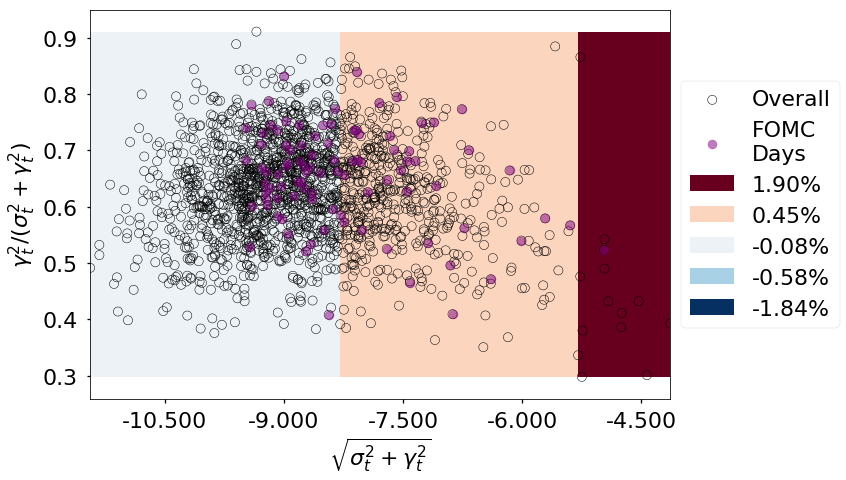

In [83]:
contour_fig, contour_ax = mpl.pyplot.subplots()

contour_ax.set_xlabel('$\sqrt{\sigma^2_t + \gamma^2_t}$')
contour_ax.set_ylabel('$ \gamma^2_t / (\sigma^2_t +\gamma^2_t)$')
labels = np.asarray([np.mean(data.daily_rtn[np.digitize(data.daily_rtn, bins=levels.iloc[1:]) == val])
                     for val in range(len(levels) -1)])
contour_colors = cm.RdBu_r(skprocess.normalize(labels.reshape(1,-1) - labels.min(), norm='max').ravel())
cs = contour_ax.contourf(X,Y,Z, levels=levels, colors=contour_colors)
proxy = [mpl.pyplot.Rectangle((0,0),1,1, fc = pc.get_facecolor()[0]) for pc in cs.collections]
formatted_labels = ['{:.2f}%'.format(100 * val) for val in labels]
contour_ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: '{:.3f}'.format(x)))
contour_ax.xaxis.set_major_locator(ticker.MaxNLocator(5))

contour_ax.scatter(y=announcement_data.jump_prop, x=announcement_data.root_quad, color='purple', zorder=10, alpha=.5,
             label='FOMC\nDays')
contour_ax.set_xlim([data.root_quad.min(), data.root_quad.max()])
contour_ax.scatter(x=data.root_quad, y=data.jump_prop, facecolor='none', edgecolor='black', 
                   alpha=1,linewidth=.5, label='Overall')
handles2, labels2 = contour_ax.get_legend_handles_labels()

contour_ax.legend(reversed(proxy + list(handles2)), reversed(formatted_labels + list(labels2)), 
                  loc='center left', bbox_to_anchor=(1, .5))

# contour_fig.savefig('../doc/figures/jump_prop_rt_countor.tmp.pdf', transparent=True, frameon=False,
#                     bbox_inches='tight', pad_inches=0)

In [36]:
[set_model_params(neighbors.KNeighborsRegressor, n_neighbors=n, n_splits=100) for n in n_neigbors_arr]

[(1.0442096462538402, {'n_neighbors': 10}),
 (1.0218328031056938, {'n_neighbors': 20}),
 (1.0141754885595986, {'n_neighbors': 30}),
 (1.0096996747077029, {'n_neighbors': 40}),
 (1.0045234801230039, {'n_neighbors': 50}),
 (1.0029037771369025, {'n_neighbors': 60}),
 (0.99836402040551608, {'n_neighbors': 70}),
 (0.99831030742896842, {'n_neighbors': 80})]